## Text embedding

In [1]:
import clip
import torch
import numpy as np
import pandas as pd
from models import CLIPModel

# a much smaller subset of above prompts
# from https://github.com/openai/CLIP/blob/main/notebooks/Prompt_Engineering_for_ImageNet.ipynb
SIMPLE_IMAGENET_TEMPLATES = (
    # 原始模板
    lambda c: f"itap of a {c}.",
    lambda c: f"a bad photo of the {c}.",
    lambda c: f"a origami {c}.",
    lambda c: f"a photo of the large {c}.",
    lambda c: f"a {c} in a video game.",
    lambda c: f"art of the {c}.",
    lambda c: f"a photo of the small {c}.",

    # 新增模板
#     lambda c: f"a painting of a {c}.",
#     lambda c: f"a sculpture of the {c}.",
#     lambda c: f"a digital illustration of the {c}.",
#     lambda c: f"a {c} in a children's book.",
#     lambda c: f"a cartoon {c}.",
#     lambda c: f"a graffiti of the {c}.",
)


def get_prompt(words, index, device="cuda"):
    prompt = [SIMPLE_IMAGENET_TEMPLATES[index](word) for word in words]
    text = clip.tokenize(prompt, truncate=True).to(device)
    return text


nouns = pd.read_csv("./WordNetNouns.csv").values
nouns_num = nouns.shape[0]
batch_size = 2048
model = CLIPModel(model_name="ViT-B/32").cuda()
model.eval()

for index in range(len(SIMPLE_IMAGENET_TEMPLATES)):
    features = []
    print("Inferring text features for index", index)
    for i in range(nouns_num // batch_size + 1):
        start = i * batch_size
        end = start + batch_size
        if end > nouns_num:
            end = nouns_num
        nouns_batch = nouns[start:end]
        with torch.no_grad():
            prompt = get_prompt(nouns_batch[:, 0], index)
            feature = model.encode_text(prompt)
            features.append(feature.cpu().numpy())
        if i % 50 == 0:
            print(f"[Completed {i * batch_size}/{nouns_num}]")
    features = np.concatenate(features, axis=0)
    print("Feature shape:", features.shape)
    np.save("./nouns_embedding_prompt_" + str(index) + ".npy", features)


# Multi Prompts
embeddings = np.zeros((nouns_num, 512))
for index in range(len(SIMPLE_IMAGENET_TEMPLATES)):
    embedding = np.load("./nouns_embedding_prompt_" + str(index) + ".npy")
    embeddings += embedding
embeddings = embeddings / len(SIMPLE_IMAGENET_TEMPLATES)
np.save("./nouns_embedding_ensemble.npy", embeddings)


/root/miniconda3/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Inferring text features for index 0
[Completed 0/146347]
[Completed 102400/146347]
Feature shape: (146347, 512)
Inferring text features for index 1
[Completed 0/146347]
[Completed 102400/146347]
Feature shape: (146347, 512)
Inferring text features for index 2
[Completed 0/146347]
[Completed 102400/146347]
Feature shape: (146347, 512)
Inferring text features for index 3
[Completed 0/146347]
[Completed 102400/146347]
Feature shape: (146347, 512)
Inferring text features for index 4
[Completed 0/146347]
[Completed 102400/146347]
Feature shape: (146347, 512)
Inferring text features for index 5
[Completed 0/146347]
[Completed 102400/146347]
Feature shape: (146347, 512)
Inferring text features for index 6
[Completed 0/146347]
[Completed 102400/146347]
Feature shape: (146347, 512)


## Image embedding

In [3]:
import copy
import torch
import data_utils
import numpy as np
from models import CLIPModel

dataset = "CIFAR-10" #　["CIFAR-10", "CIFAR-20", "STL-10", "ImageNet-10", "ImageNet-Dogs", "DTD", "UCF101", "ImageNet"]

dataloader_train, dataloader_test = data_utils.get_dataloader(
    dataset=dataset, batch_size=1024
)
model = CLIPModel(model_name="ViT-B/32").cuda()
model.eval()

features = []
labels = []
print("Inferring image features and labels...")
for iteration, (x, y) in enumerate(dataloader_train):
    x = x.cuda()
    with torch.no_grad():
        feature = model.encode_image(x)
    features.append(feature.cpu().numpy())
    labels.append(y.numpy())
    if iteration % 10 == 0:
        print(f"[Iter {iteration}/{len(dataloader_train)}]")
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)
print("Feature shape:", features.shape, "Label shape:", labels.shape)

features_test = []
labels_test = []
print("Inferring test image features and labels...")
for iteration, (x, y) in enumerate(dataloader_test):
    x = x.cuda()
    with torch.no_grad():
        feature = model.encode_image(x)
    features_test.append(feature.cpu().numpy())
    labels_test.append(y.numpy())
    if iteration % 10 == 0:
        print(f"[Iter {iteration}/{len(dataloader_test)}]")
features_test = np.concatenate(features_test, axis=0)
labels_test = np.concatenate(labels_test, axis=0)
print("Feature shape:", features_test.shape, "Label shape:", labels_test.shape)

if dataset == "CIFAR-20":
    coarse_label = [
        [72, 4, 95, 30, 55],
        [73, 32, 67, 91, 1],
        [92, 70, 82, 54, 62],
        [16, 61, 9, 10, 28],
        [51, 0, 53, 57, 83],
        [40, 39, 22, 87, 86],
        [20, 25, 94, 84, 5],
        [14, 24, 6, 7, 18],
        [43, 97, 42, 3, 88],
        [37, 17, 76, 12, 68],
        [49, 33, 71, 23, 60],
        [15, 21, 19, 31, 38],
        [75, 63, 66, 64, 34],
        [77, 26, 45, 99, 79],
        [11, 2, 35, 46, 98],
        [29, 93, 27, 78, 44],
        [65, 50, 74, 36, 80],
        [56, 52, 47, 59, 96],
        [8, 58, 90, 13, 48],
        [81, 69, 41, 89, 85],
    ]
    labels_copy = copy.deepcopy(labels)
    labels_test_copy = copy.deepcopy(labels_test)
    for i in range(20):
        for j in coarse_label[i]:
            labels[labels_copy == j] = i
            labels_test[labels_test_copy == j] = i

np.save("./" + dataset + "_image_embedding_train.npy", features)
np.save("./" + dataset + "_image_embedding_test.npy", features_test)
np.savetxt("./" + dataset + "_labels_train.txt", labels)
np.savetxt("./" + dataset + "_labels_test.txt", labels_test)


Files already downloaded and verified
Files already downloaded and verified
Inferring image features and labels...
[Iter 0/49]
[Iter 10/49]
[Iter 20/49]
[Iter 30/49]
[Iter 40/49]
Feature shape: (50000, 512) Label shape: (50000,)
Inferring test image features and labels...
[Iter 0/10]
Feature shape: (10000, 512) Label shape: (10000,)


## Semantics Granularity Determination

In [4]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def feature_representation(image):
    # Convert the image to a feature vector (e.g., intensity, color, texture)
    return image.reshape(-1, 3)  # Assuming a color image with RGB channels


def calculate_gene_force(image, k=5, w_attr=1.0, w_rep=1.0):
    if len(image.shape) > 2:
        height, width, _ = image.shape
        features = feature_representation(image)
    else:
        height, width = image.shape
        features = image

    # Check for NaN values and handle if present
    if np.isnan(features).any():
        features = np.nan_to_num(features)

    # Normalize features
    # features = (features - features.mean(axis=0)) / features.std(axis=0)

    # K-Nearest Neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(features)
    distances, indices = knn.kneighbors(features)

    # 用于存储每个点基因力大于等于周围点基因力的个数
    greater_count = np.zeros(features.shape[0], dtype=int)
    for i in range(features.shape[0]):
        current_force = np.zeros(features.shape[1])
        for j in range(1, k):
            neighbor_index = indices[i, j]
            distance = distances[i, j]
            if distance == 0:
                continue
            # 计算吸引力部分
            F_attr = (w_attr / distance) * (features[neighbor_index] - features[i])
            # 计算排斥力部分
            F_rep = (w_rep / (distance ** 2)) * (features[i] - features[neighbor_index])
            current_force += F_attr - F_rep

        current_force_norm = np.linalg.norm(current_force)  # 计算当前点基因力的模长

        # 与周围8个点（这里假设k足够大包含了8个点，可根据实际调整k）比较基因力模长并计数
        neighbor_indices = indices[i, 1:9]  # 获取周围8个点的索引，可根据实际调整范围
        for neighbor_idx in neighbor_indices:
            neighbor_force = np.zeros(features.shape[1])
            for m in range(1, k):
                nbr_distance = distances[neighbor_idx, m]
                if nbr_distance == 0:
                    continue
                nbr_F_attr = (w_attr / nbr_distance) * (features[indices[neighbor_idx, m]] - features[neighbor_idx])
                nbr_F_rep = (w_rep / (nbr_distance ** 2)) * (features[neighbor_idx] - features[indices[neighbor_idx, m]])
                neighbor_force += nbr_F_attr - nbr_F_rep
            neighbor_force_norm = np.linalg.norm(neighbor_force)  # 计算周围点基因力的模长
            if current_force_norm >= neighbor_force_norm:
                greater_count[i] += 1

    return greater_count


def edge_strength(total_force):
    return np.linalg.norm(total_force, axis=1)


def edge_detection(image, k, w_attr, w_rep, T):
    greater_count = calculate_gene_force(image, k, w_attr, w_rep)
    return greater_count
import numpy as np
from sklearn.neighbors import NearestNeighbors

def feature_representation2(image):
    # Convert the image to a feature vector (e.g., intensity, color, texture)
    return image.reshape(-1, 3)  # Assuming a color image with RGB channels

def calculate_gene_force2(image, k=5, w_attr=1.0, w_rep=1.0):
    if len(image.shape)>2:
        height, width, _ = image.shape
        features = feature_representation(image)
    else:
        height, width= image.shape
        features =image
    # Check for NaN values and handle if present
    if np.isnan(features).any():
        features = np.nan_to_num(features)
    # Normalize features
    #features = (features - features.mean(axis=0)) / features.std(axis=0)
    # K-Nearest Neighbors
    knn = NearestNeighbors(n_neighbors=k)

    knn.fit(features)
    distances, indices = knn.kneighbors(features)
    # Initialize forces
    total_force = np.zeros(features.shape)
    for i in range(features.shape[0]):
        F_attr = np.zeros(features.shape[1])
        F_rep = np.zeros(features.shape[1])
        for j in range(1,k):
            neighbor_index = indices[i, j]
            distance = distances[i, j]
            # Attractive force
            if distance==0:
                continue
            F_attr += (w_attr / distance) * (features[neighbor_index] - features[i])
            F_rep += (w_rep / (distance ** 2)) * (features[i] - features[neighbor_index])
        # Total force
        total_force[i] = F_attr - F_rep
    return total_force

def edge_strength2(total_force):
    return np.linalg.norm(total_force, axis=1)

def edge_detection(image,k,w_attr,w_rep,T):
    total_force = calculate_gene_force2(image,k,w_attr,w_rep)
    if len(image.shape)>2:
        strength = edge_strength(total_force).reshape(image.shape[:2])
    else:
        strength = edge_strength2(total_force)
    # Thresholding
    print(int(T*len(total_force))-1)
    threshold=np.sort(strength.flatten())[int(T*len(total_force))-1]
    #threshold=np.mean(strength)
    #找中心
    edges = (strength >= threshold).astype(np.uint8)
    return edges

In [5]:
import numpy as np
dataset = "CIFAR-10"  # ["CIFAR-10", "CIFAR-20", "STL-10", "ImageNet-10", "ImageNet-Dogs", "DTD", "UCF101", "ImageNet"]
images_embedding_train = np.load("./" + dataset + "_image_embedding_train.npy")
images_embedding_test = np.load("./" + dataset + "_image_embedding_test.npy")
images_embedding=np.concatenate([images_embedding_train, images_embedding_test], axis=0)
k=9
w_attr=1
w_rep=0.5
total_force_values_image = calculate_gene_force2(images_embedding,k,w_attr,w_rep)
total_force_strength_image = edge_strength2(total_force_values_image)



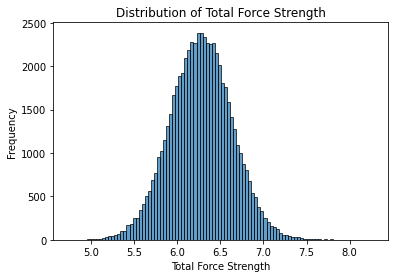

均值为: 6.2748080634549055
偏度为: 0.028936071175337044
标准差为: 0.3604028823929673
范围1: 5.914405181061938-6.635210945847873
范围2: 5.554002298668971-6.99561382824084


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

# 绘制直方图
plt.hist(total_force_strength_image, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Total Force Strength')
plt.ylabel('Frequency')
plt.title('Distribution of Total Force Strength')
plt.show()

# 计算均值
mean_value = np.mean(total_force_strength_image)
print(f"均值为: {mean_value}")
skewness = skew(total_force_strength_image)
print(f"偏度为: {skewness}")
# 计算标准差
std_value = np.std(total_force_strength_image)
print(f"标准差为: {std_value}")
print(f"范围1: {mean_value-std_value}-{mean_value+std_value}")
print(f"范围2: {mean_value-2*std_value}-{mean_value+2*std_value}")

In [7]:
a=0.005
mask=(total_force_strength_image>=mean_value-a*std_value)&(total_force_strength_image<=mean_value+a*std_value)
cluster_num_best_de=len(total_force_strength_image[mask])
cluster_num_best_de

257

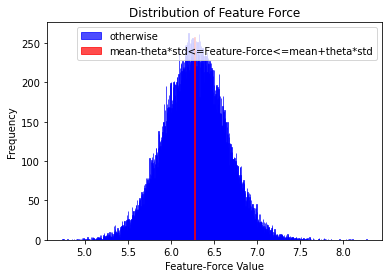

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

# 提取符合条件的数据
data_yes_mask = total_force_strength_image[mask]
# 提取不符合条件的数据
data_no_mask = total_force_strength_image[~mask]

# 绘制符合mask条件的直方图，设置颜色等属性


# 绘制不符合mask条件的直方图，设置颜色等属性
plt.hist(data_no_mask, bins=1000, edgecolor='blue', alpha=0.7, color='blue', label='otherwise')
plt.hist(data_yes_mask, bins=1, edgecolor='red', alpha=0.7, color='red', label='mean-theta*std<=Feature-Force<=mean+theta*std')

plt.xlabel('Feature-Force Value')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Force')

# 添加图例，方便区分不同颜色代表的部分
plt.legend()

plt.show()

## Filter Nouns

In [9]:
import torch
import faiss
import numpy as np
import torch.nn.functional as F


def kmeans(X, cluster_num):
    print("Perform K-means clustering...")
    d = X.shape[1]
    X = X.astype(np.float32)
    kmeans = faiss.Kmeans(d, cluster_num, gpu=True, spherical=True, niter=300, nredo=10)
    kmeans.train(X)
    D, I = kmeans.index.search(X, 1)
    I = I.reshape(-1)
    print("K-means clustering done.")
    return I


if __name__ == "__main__":
    dataset = "CIFAR-10"  # ["CIFAR-10", "CIFAR-20", "STL-10", "ImageNet-10", "ImageNet-Dogs", "DTD", "UCF101", "ImageNet"]
    #cluster_num = 279  # [167, 167, 17, 43, 65, 141, 303, 4271]
    topK = 5

    nouns_embedding = np.load("./nouns_embedding_ensemble.npy")
    nouns_embedding = nouns_embedding / np.linalg.norm(
        nouns_embedding, axis=1, keepdims=True
    )
    #images_embedding = np.load("./" + dataset + "_image_embedding_test.npy")


    images_embedding = images_embedding / np.linalg.norm(
        images_embedding, axis=1, keepdims=True
    )

    nouns_embedding = torch.from_numpy(nouns_embedding).cuda().half()
    nouns_num = nouns_embedding.shape[0]

    images_embedding = torch.from_numpy(images_embedding).cuda().half()
    image_num = images_embedding.shape[0]

    
    
    cluster_num_best=cluster_num_best_de
    print(cluster_num_best)
    try:
        preds = np.load(
            "./" + dataset + "_image_" + str(cluster_num_best) + "cluster.npy"
        )
    except:
        preds = kmeans(images_embedding.cpu().numpy(), cluster_num_best)
        np.save(
            "./" + dataset + "_image_" + str(cluster_num_best) + "cluster.npy", preds
        )
        print("Please rerun the script.")
        exit()

    image_centers = torch.zeros((cluster_num_best, 512), dtype=torch.float16).cuda()
    for k in range(cluster_num_best):
        image_centers[k] = images_embedding[preds == k].mean(dim=0)
    image_centers = F.normalize(image_centers, dim=1)

    similarity = torch.matmul(image_centers, nouns_embedding.T)
    softmax_nouns = torch.softmax(similarity, dim=0).cpu().float()
    class_pred = torch.argmax(softmax_nouns, dim=0).long()

    selected_idx = torch.zeros_like(class_pred, dtype=torch.bool)
    for k in range(cluster_num_best):
        if (class_pred == k).sum() == 0:
            continue
        class_index = torch.where(class_pred == k)[0]
        softmax_class = softmax_nouns[:, class_index]
        confidence = softmax_class.max(dim=0)[0]
        rank = torch.argsort(confidence, descending=True)
        selected_idx[class_index[rank[:topK]]] = True
    selected_idx = selected_idx.cpu().numpy()

    print(selected_idx.sum(), "nouns selected.")
    nouns_embedding_selected = nouns_embedding[selected_idx]

    np.save(
        "./" + dataset + "_filtered_nouns_embedding.npy",
        nouns_embedding_selected.cpu().numpy(),
    )


257
1087 nouns selected.


## Concatenate Embedding

In [1]:
import torch
import faiss
import warnings
import numpy as np
import torch.nn.functional as F
from eval_utils import cluster_metric


warnings.simplefilter("ignore")


def kmeans(X, cluster_num):
    print("Perform K-means clustering...")
    d = X.shape[1]
    kmeans = faiss.Kmeans(d, cluster_num, gpu=True, spherical=True, niter=300, nredo=20)
    X = X.astype(np.float32)
    kmeans.train(X)
    D, I = kmeans.index.search(X, 1)
    I = I.reshape(-1)
    print("K-means clustering done.")
    return I


if __name__ == "__main__":
    dataset = "CIFAR-10"  # 　["CIFAR-10", "CIFAR-20", "STL-10", "ImageNet-10", "ImageNet-Dogs", "DTD", "UCF101", "ImageNet"]
    tau = 0.005
    if dataset == "CIFAR-10" or dataset == "STL-10" or dataset == "ImageNet-10":
        cluster_num = 10
    elif dataset == "CIFAR-20":
        cluster_num = 20
    elif dataset == "ImageNet-Dogs":
        cluster_num = 15
    elif dataset == "DTD":
        cluster_num = 47
    elif dataset == "UCF101":
        cluster_num = 101
    elif dataset == "ImageNet":
        cluster_num = 1000
    elif dataset == "MNIST":
        cluster_num = 10
    else:
        raise NotImplementedError

    images_embedding_test = np.load("./" + dataset + "_image_embedding_test.npy")
    images_embedding_test = images_embedding_test / np.linalg.norm(
        images_embedding_test, axis=1, keepdims=True
    )
    labels_test = np.loadtxt("./" + dataset + "_labels_test.txt")

    nouns_embedding = np.load("./" + dataset + "_filtered_nouns_embedding.npy")
    nouns_embedding = nouns_embedding / np.linalg.norm(
        nouns_embedding, axis=1, keepdims=True
    )

    nouns_embedding = torch.from_numpy(nouns_embedding).cuda().half()
    nouns_num = nouns_embedding.shape[0]
    images_embedding_test = torch.from_numpy(images_embedding_test).cuda().half()
    image_num_test = images_embedding_test.shape[0]

    retrieval_embeddings = []
    batch_size = 1024
    for i in range(image_num_test // batch_size + 1):
        start = i * batch_size
        end = start + batch_size
        if end > image_num_test:
            end = image_num_test
            images_batch = images_embedding_test[start:end]
        similarity = torch.matmul(images_embedding_test[start:end], nouns_embedding.T)
        similarity = torch.softmax(similarity / tau, dim=1)
        retrieval_embedding = (similarity @ nouns_embedding).cpu()
        retrieval_embeddings.append(retrieval_embedding)
    retrieval_embedding = torch.cat(retrieval_embeddings, dim=0).cuda().half()
    retrieval_embedding = F.normalize(retrieval_embedding, dim=1).cpu().numpy()
    images_embedding_test = images_embedding_test.cpu().numpy()

    concat_embedding_test = np.concatenate([images_embedding_test, retrieval_embedding], axis=1)
    preds_ = kmeans(concat_embedding_test, cluster_num)
    cluster_metric(labels_test, preds_)


Perform K-means clustering...
K-means clustering done.
[Clustering Result]: ACC = 90.67, NMI = 81.54, ARI = 80.77


In [2]:
import torch
import faiss
import warnings
import numpy as np
import torch.nn.functional as F
from eval_utils import cluster_metric


warnings.simplefilter("ignore")


def kmeans(X, cluster_num):
    print("Perform K-means clustering...")
    d = X.shape[1]
    kmeans = faiss.Kmeans(d, cluster_num, gpu=True, spherical=True, niter=300, nredo=20)
    X = X.astype(np.float32)
    kmeans.train(X)
    D, I = kmeans.index.search(X, 1)
    I = I.reshape(-1)
    print("K-means clustering done.")
    return I


if __name__ == "__main__":
    dataset = "CIFAR-10"  # 　["CIFAR-10", "CIFAR-20", "STL-10", "ImageNet-10", "ImageNet-Dogs", "DTD", "UCF101", "ImageNet"]
    tau = 0.005
    if dataset == "CIFAR-10" or dataset == "STL-10" or dataset == "ImageNet-10":
        cluster_num = 10
    elif dataset == "CIFAR-20":
        cluster_num = 20
    elif dataset == "ImageNet-Dogs":
        cluster_num = 15
    elif dataset == "DTD":
        cluster_num = 47
    elif dataset == "UCF101":
        cluster_num = 101
    elif dataset == "ImageNet":
        cluster_num = 1000
    elif dataset == "MNIST":
        cluster_num = 10
    else:
        raise NotImplementedError

    images_embedding_train = np.load("./" + dataset + "_image_embedding_train.npy")
    images_embedding_train = images_embedding_train / np.linalg.norm(
        images_embedding_train, axis=1, keepdims=True
    )
    labels_train = np.loadtxt("./" + dataset + "_labels_train.txt")

    nouns_embedding = np.load("./" + dataset + "_filtered_nouns_embedding.npy")
    nouns_embedding = nouns_embedding / np.linalg.norm(
        nouns_embedding, axis=1, keepdims=True
    )

    nouns_embedding = torch.from_numpy(nouns_embedding).cuda().half()
    nouns_num = nouns_embedding.shape[0]
    images_embedding_train = torch.from_numpy(images_embedding_train).cuda().half()
    image_num_train = images_embedding_train.shape[0]

    retrieval_embeddings = []
    batch_size = 1024
    for i in range(image_num_train // batch_size + 1):
        start = i * batch_size
        end = start + batch_size
        if end > image_num_train:
            end = image_num_train
            images_batch = images_embedding_train[start:end]
        similarity = torch.matmul(images_embedding_train[start:end], nouns_embedding.T)
        similarity = torch.softmax(similarity / tau, dim=1)
        retrieval_embedding = (similarity @ nouns_embedding).cpu()
        retrieval_embeddings.append(retrieval_embedding)
    retrieval_embedding = torch.cat(retrieval_embeddings, dim=0).cuda().half()
    retrieval_embedding = F.normalize(retrieval_embedding, dim=1).cpu().numpy()
    images_embedding_train = images_embedding_train.cpu().numpy()

    concat_embedding_train = np.concatenate([images_embedding_train, retrieval_embedding], axis=1)
    preds_train = kmeans(concat_embedding_train, cluster_num)
    cluster_metric(labels_train, preds_train)


Perform K-means clustering...
K-means clustering done.
[Clustering Result]: ACC = 90.64, NMI = 81.40, ARI = 80.70


In [3]:
concat_embedding=np.concatenate([concat_embedding_train, concat_embedding_test], axis=0)
labels=np.concatenate([labels_train, labels_test])

In [4]:
print(concat_embedding.shape)
preds = kmeans(concat_embedding, cluster_num)
cluster_metric(labels, preds)

(60000, 1024)
Perform K-means clustering...
K-means clustering done.
[Clustering Result]: ACC = 76.44, NMI = 76.82, ARI = 69.19


## Feature Force Computation & Pseudo label Generation

In [5]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def feature_representation(image):
    # Convert the image to a feature vector (e.g., intensity, color, texture)
    return image.reshape(-1, 3)  # Assuming a color image with RGB channels


def calculate_gene_force(image, k=5, w_attr=1.0, w_rep=1.0):
    if len(image.shape) > 2:
        height, width, _ = image.shape
        features = feature_representation(image)
    else:
        height, width = image.shape
        features = image

    # Check for NaN values and handle if present
    if np.isnan(features).any():
        features = np.nan_to_num(features)

    # Normalize features
    # features = (features - features.mean(axis=0)) / features.std(axis=0)

    # K-Nearest Neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(features)
    distances, indices = knn.kneighbors(features)

    # 用于存储每个点基因力大于等于周围点基因力的个数
    greater_count = np.zeros(features.shape[0], dtype=int)
    for i in range(features.shape[0]):
        current_force = np.zeros(features.shape[1])
        for j in range(1, k):
            neighbor_index = indices[i, j]
            distance = distances[i, j]
            if distance == 0:
                continue
            # 计算吸引力部分
            F_attr = (w_attr / distance) * (features[neighbor_index] - features[i])
            # 计算排斥力部分
            F_rep = (w_rep / (distance ** 2)) * (features[i] - features[neighbor_index])
            current_force += F_attr - F_rep

        current_force_norm = np.linalg.norm(current_force)  # 计算当前点基因力的模长

        # 与周围8个点（这里假设k足够大包含了8个点，可根据实际调整k）比较基因力模长并计数
        neighbor_indices = indices[i, 1:9]  # 获取周围8个点的索引，可根据实际调整范围
        for neighbor_idx in neighbor_indices:
            neighbor_force = np.zeros(features.shape[1])
            for m in range(1, k):
                nbr_distance = distances[neighbor_idx, m]
                if nbr_distance == 0:
                    continue
                nbr_F_attr = (w_attr / nbr_distance) * (features[indices[neighbor_idx, m]] - features[neighbor_idx])
                nbr_F_rep = (w_rep / (nbr_distance ** 2)) * (features[neighbor_idx] - features[indices[neighbor_idx, m]])
                neighbor_force += nbr_F_attr - nbr_F_rep
            neighbor_force_norm = np.linalg.norm(neighbor_force)  # 计算周围点基因力的模长
            if current_force_norm >= neighbor_force_norm:
                greater_count[i] += 1

    return greater_count


def edge_strength(total_force):
    return np.linalg.norm(total_force, axis=1)


def edge_detection(image, k, w_attr, w_rep, T):
    greater_count = calculate_gene_force(image, k, w_attr, w_rep)
    return greater_count
import numpy as np
from sklearn.neighbors import NearestNeighbors

def feature_representation2(image):
    # Convert the image to a feature vector (e.g., intensity, color, texture)
    return image.reshape(-1, 3)  # Assuming a color image with RGB channels

def calculate_gene_force2(image, k=5, w_attr=1.0, w_rep=1.0):
    if len(image.shape)>2:
        height, width, _ = image.shape
        features = feature_representation(image)
    else:
        height, width= image.shape
        features =image
    # Check for NaN values and handle if present
    if np.isnan(features).any():
        features = np.nan_to_num(features)
    # Normalize features
    #features = (features - features.mean(axis=0)) / features.std(axis=0)
    # K-Nearest Neighbors
    knn = NearestNeighbors(n_neighbors=k)

    knn.fit(features)
    distances, indices = knn.kneighbors(features)
    # Initialize forces
    total_force = np.zeros(features.shape)
    for i in range(features.shape[0]):
        F_attr = np.zeros(features.shape[1])
        F_rep = np.zeros(features.shape[1])
        for j in range(1,k):
            neighbor_index = indices[i, j]
            distance = distances[i, j]
            # Attractive force
            if distance==0:
                continue
            F_attr += (w_attr / distance) * (features[neighbor_index] - features[i])
            F_rep += (w_rep / (distance ** 2)) * (features[i] - features[neighbor_index])
        # Total force
        total_force[i] = F_attr - F_rep
    return total_force

def edge_strength2(total_force):
    return np.linalg.norm(total_force, axis=1)

def edge_detection(image,k,w_attr,w_rep,T):
    total_force = calculate_gene_force2(image,k,w_attr,w_rep)
    if len(image.shape)>2:
        strength = edge_strength(total_force).reshape(image.shape[:2])
    else:
        strength = edge_strength2(total_force)
    # Thresholding
    print(int(T*len(total_force))-1)
    threshold=np.sort(strength.flatten())[int(T*len(total_force))-1]
    #threshold=np.mean(strength)
    #找中心
    edges = (strength >= threshold).astype(np.uint8)
    return edges

In [6]:
k=9
w_attr=1
w_rep=0.5
total_force_values = calculate_gene_force2(concat_embedding,k,w_attr,w_rep)
total_force_strength = edge_strength2(total_force_values)
#total_force_strength = np.load("./" + dataset + "_total_force_strength.npy")


In [6]:
np.save("./" + dataset + "_total_force_strength.npy", total_force_strength)

In [7]:
def adjust_strength_based_on_threshold(strength, global_threshold):
    adjusted_strength = np.copy(strength)
    for i in range(len(strength)):
        if strength[i] < global_threshold:
            adjusted_strength[i] = (global_threshold-strength[i])
        elif strength[i] > global_threshold:
            adjusted_strength[i] = adjusted_strength[i]-global_threshold
    return adjusted_strength
total_force_strength=adjust_strength_based_on_threshold(total_force_strength, np.percentile(total_force_strength, 80))

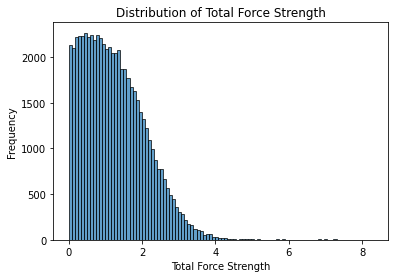

均值为: 1.2486282407538882
偏度为: 0.8876545993983279
标准差为: 0.8510699952568098
范围1: 0.3975582454970784-2.099698236010698
范围2: -0.4535117497597314-2.950768231267508


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

plt.hist(total_force_strength, bins=100, edgecolor='black', alpha=0.7)

plt.xlabel('Total Force Strength')
plt.ylabel('Frequency')
plt.title('Distribution of Total Force Strength')
plt.show()

# 计算均值
mean_value = np.mean(total_force_strength)
print(f"均值为: {mean_value}")
skewness = skew(total_force_strength)
print(f"偏度为: {skewness}")
# 计算标准差
std_value = np.std(total_force_strength)
print(f"标准差为: {std_value}")
print(f"范围1: {mean_value-std_value}-{mean_value+std_value}")
print(f"范围2: {mean_value-2*std_value}-{mean_value+2*std_value}")

In [9]:
## sita=2

mask=(total_force_strength <=1.8)
#(total_force_strength <=mean_value+sita*std_value)&(total_force_strength >=mean_value-sita*std_value)

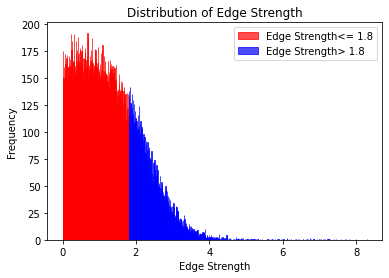

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

# 提取符合条件的数据
data_yes_mask = total_force_strength[mask]
# 提取不符合条件的数据
data_no_mask = total_force_strength[~mask]

# 绘制符合mask条件的直方图，设置颜色等属性
plt.hist(data_yes_mask, bins=300, edgecolor='red', alpha=0.7, color='red', label='Edge Strength<= 1.8')

# 绘制不符合mask条件的直方图，设置颜色等属性
plt.hist(data_no_mask, bins=1000, edgecolor='blue', alpha=0.7, color='blue', label='Edge Strength> 1.8')

plt.xlabel('Edge Strength')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Strength')

# 添加图例，方便区分不同颜色代表的部分
plt.legend()

plt.show()

In [11]:
len(data_yes_mask)/len(mask)

0.7520333333333333

In [12]:
def kmeans(X, cluster_num):
    print("Perform K-means clustering...")
    d = X.shape[1]
    kmeans = faiss.Kmeans(d, cluster_num, gpu=True, spherical=True, niter=300, nredo=20)
    X = X.astype(np.float32)
    kmeans.train(X)
    D, I = kmeans.index.search(X, 1)
    I = I.reshape(-1)
    print("K-means clustering done.")
    return I
preds = kmeans(concat_embedding[mask], cluster_num)
cluster_metric(labels[mask], preds)

Perform K-means clustering...
K-means clustering done.
[Clustering Result]: ACC = 94.16, NMI = 87.49, ARI = 87.86


In [13]:
len(labels[mask])/len(labels)

0.7520333333333333

## PSEUDO TRAIN STARTING

### Stage 1: ResNet-50

In [14]:
'''
此部分代码块仅仅是为了方便观察训练过程而进行的真实标签与聚类标签的对齐，对聚类结果没有任何影响
也就是说，可以不运行此代码块
另外后续的Stage没有进行映射，可以看出仅仅影响了我们对直观准确率的观察，最终聚类结果没有影响
'''
import numpy as np
from sklearn import metrics
from munkres import Munkres
def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))
    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:, j])  # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i, j]
            cost_matrix[j, i] = s - t
    return cost_matrix


def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    cluster_labels = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_labels[i] = indices[i][1]
    return cluster_labels


def get_y_preds(y_true, cluster_assignments, n_clusters):
    """
    Computes the predicted labels, where label assignments now
    correspond to the actual labels in y_true (as estimated by Munkres)
    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset
    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    """
    confusion_matrix = metrics.confusion_matrix(
        y_true, cluster_assignments, labels=None
    )
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)

    if np.min(cluster_assignments) != 0:
        cluster_assignments = cluster_assignments - np.min(cluster_assignments)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred
#labels = np.loadtxt("./" + dataset + "_labels_test.txt")
train_labels = get_y_preds(labels[mask], preds, 10)
metrics.accuracy_score(train_labels,labels[mask])


0.9415806036966446

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from torch.utils.data import ConcatDataset

# 定义数据变换（这里假设myTransforms已经在别处定义好了，你可以根据实际需求调整变换方式）

pseudo_labels = torch.tensor(train_labels)  # 假设是10分类任务，生成对应长度的伪标签

# 之前定义的原始数据预处理操作（保持不变）
myTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载STL10训练数据集
dataset1 =  torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=myTransforms)
dataset2 =  torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=myTransforms)
train_dataset = ConcatDataset([dataset1, dataset2])
mask_list = [mask]

# 用于存储从train_dataset中根据掩码提取出来的数据和对应的伪标签
subset_images = []

# 依次根据掩码从train_dataset中提取数据并合并
for mask in mask_list:
    # 将掩码转换为布尔索引（如果不是布尔类型的话，需要进行相应转换）
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask).astype(bool)
    # 根据布尔索引从train_dataset中获取图像数据
    subset_images.extend([train_dataset[i][0] for i in np.where(mask)[0]])
    # 这里假设伪标签的获取方式是和图像数据对应的，你可以根据实际情况调整获取逻辑

# 将合并后的数据和标签转换为Tensor类型
subset_images = torch.stack(subset_images)

# 创建自定义的Dataset，将合并后的数据和标签组合在一起
combined_dataset = TensorDataset(subset_images, pseudo_labels)

# 创建DataLoader，设置合适的参数，比如批量大小（batch_size）、是否打乱数据（shuffle）等
batch_size = 32  # 可根据实际需求调整批量大小
train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print("训练数据加载器train_loader已创建成功！")

Files already downloaded and verified
Files already downloaded and verified
训练数据加载器train_loader已创建成功！


In [16]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter



# 定义数据预处理操作
myTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载训练数据集
#train_dataset = torchvision.datasets.CIFAR10(root='./data/', train=True, download=True, transform=myTransforms)
# 使用DataLoader加载训练数据，设置合适的batch_size、shuffle以及利用多进程加速数据加载（num_workers设为4，可根据实际调整）
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# 加载测试数据集
test_dataset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=myTransforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# 定义模型，加载预训练的ResNet50模型，并替换最后一层全连接层以适应CIFAR10的10分类任务
myModel = torchvision.models.resnet50(pretrained=True)
inchannel = myModel.fc.in_features
myModel.fc = nn.Linear(inchannel, 10)

# 将模型移动到GPU（如果可用）进行加速
myDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(myDevice)

# 定义学习率、优化器和损失函数
learning_rate = 0.001
myOptimzier = optim.SGD(myModel.parameters(), lr=learning_rate, momentum=0.9)
myLoss = torch.nn.CrossEntropyLoss()

for _epoch in range(50):
    training_loss = 0.0
    for _step, input_data in enumerate(train_loader):
        image, label = input_data[0].to(myDevice), input_data[1].to(myDevice)
        image = image.float()
        predict_label = myModel(image)
        predict_label = predict_label.float()
        label = label.long()
        loss = myLoss(predict_label, label)

        # 将当前批次的损失添加到TensorBoard中记录
        
        # 优化器梯度清零，使用更高效的方式（set_to_none=True，需PyTorch 1.7及以上版本支持）
        myOptimzier.zero_grad(set_to_none=True)
        loss.backward()
        myOptimzier.step()

        # 累加当前批次的损失（使用更简洁的方式）
        training_loss += loss.item()

        # 每100个step打印一次训练损失，减少过多的打印输出
        if _step % 1000 == 0:
            print('[iteration - %3d] training loss: %.3f' % (_epoch * len(train_loader) + _step, training_loss / 1000))
            training_loss = 0.0
            print()

    correct = 0
    total = 0
    # 将模型设置为评估模式，关闭一些在训练时才需要的操作（如Dropout等）
    LABEL_TEST=[]
    LABEL_Prob=[]
    LABEL_TRUE=[]
    myModel.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(myDevice)
            labels = labels.to(myDevice)
            outputs = myModel(images)
            LABEL_Prob.append(outputs.data)
            _, predicted = torch.max(outputs.data, 1)
            LABEL_TEST.append(predicted.cpu().numpy())
            LABEL_TRUE.append(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    LABEL_TEST= np.concatenate(LABEL_TEST, axis=0)
    LABEL_TRUE= np.concatenate(LABEL_TRUE, axis=0)
    cluster_metric(LABEL_TRUE, LABEL_TEST)
    print('Testing Accuracy : %.3f %%' % (100 * correct / total))


2025-01-16 15:42:29.078962: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 15:42:29.144361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 15:42:30.131223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Files already downloaded and verified
[iteration -   0] training loss: 0.002

[iteration - 1000] training loss: 0.472

[Clustering Result]: ACC = 93.05, NMI = 85.84, ARI = 85.46
Testing Accuracy : 93.050 %
[iteration - 1411] training loss: 0.000

[iteration - 2411] training loss: 0.294

[Clustering Result]: ACC = 91.70, NMI = 83.18, ARI = 82.59
Testing Accuracy : 91.700 %
[iteration - 2822] training loss: 0.000

[iteration - 3822] training loss: 0.220

[Clustering Result]: ACC = 91.52, NMI = 84.15, ARI = 82.27
Testing Accuracy : 91.520 %
[iteration - 4233] training loss: 0.000

[iteration - 5233] training loss: 0.157

[Clustering Result]: ACC = 92.44, NMI = 85.00, ARI = 84.25
Testing Accuracy : 92.440 %
[iteration - 5644] training loss: 0.000

[iteration - 6644] training loss: 0.116

[Clustering Result]: ACC = 90.08, NMI = 82.16, ARI = 79.12
Testing Accuracy : 90.080 %
[iteration - 7055] training loss: 0.000

[iteration - 8055] training loss: 0.083

[Clustering Result]: ACC = 90.30, NM

In [48]:
# #保存模型方便复现
# torch.save(myModel, 'CIFAR10-myModel.pt')

### Pseudo label Generation of Stage 2

In [17]:
import torch
import faiss
import warnings
import numpy as np
import torch.nn.functional as F
from eval_utils import cluster_metric


warnings.simplefilter("ignore")


def kmeans(X, cluster_num):
    print("Perform K-means clustering...")
    d = X.shape[1]
    kmeans = faiss.Kmeans(d, cluster_num, gpu=True, spherical=True, niter=300, nredo=20)
    X = X.astype(np.float32)
    kmeans.train(X)
    D, I = kmeans.index.search(X, 1)
    I = I.reshape(-1)
    print("K-means clustering done.")
    return I


if __name__ == "__main__":
    dataset = "CIFAR-10"  # 　["CIFAR-10", "CIFAR-20", "STL-10", "ImageNet-10", "ImageNet-Dogs", "DTD", "UCF101", "ImageNet"]
    tau = 0.005
    if dataset == "CIFAR-10" or dataset == "STL-10" or dataset == "ImageNet-10":
        cluster_num = 10
    elif dataset == "CIFAR-20":
        cluster_num = 20
    elif dataset == "ImageNet-Dogs":
        cluster_num = 15
    elif dataset == "DTD":
        cluster_num = 47
    elif dataset == "UCF101":
        cluster_num = 101
    elif dataset == "ImageNet":
        cluster_num = 1000
    elif dataset == "MNIST":
        cluster_num = 10
    else:
        raise NotImplementedError

    images_embedding_test = np.load("./" + dataset + "_image_embedding_test.npy")
    images_embedding_test = images_embedding_test / np.linalg.norm(
        images_embedding_test, axis=1, keepdims=True
    )
    labels_test = np.loadtxt("./" + dataset + "_labels_test.txt")

    nouns_embedding = np.load("./" + dataset + "_filtered_nouns_embedding.npy")
    nouns_embedding = nouns_embedding / np.linalg.norm(
        nouns_embedding, axis=1, keepdims=True
    )

    nouns_embedding = torch.from_numpy(nouns_embedding).cuda().half()
    nouns_num = nouns_embedding.shape[0]
    images_embedding_test = torch.from_numpy(images_embedding_test).cuda().half()
    image_num_test = images_embedding_test.shape[0]

    retrieval_embeddings = []
    batch_size = 1024
    for i in range(image_num_test // batch_size + 1):
        start = i * batch_size
        end = start + batch_size
        if end > image_num_test:
            end = image_num_test
            images_batch = images_embedding_test[start:end]
        similarity = torch.matmul(images_embedding_test[start:end], nouns_embedding.T)
        similarity = torch.softmax(similarity / tau, dim=1)
        retrieval_embedding = (similarity @ nouns_embedding).cpu()
        retrieval_embeddings.append(retrieval_embedding)
    retrieval_embedding = torch.cat(retrieval_embeddings, dim=0).cuda().half()
    retrieval_embedding = F.normalize(retrieval_embedding, dim=1).cpu().numpy()
    images_embedding_test = images_embedding_test.cpu().numpy()

    concat_embedding_test = np.concatenate([images_embedding_test, retrieval_embedding], axis=1)
    preds_ = kmeans(concat_embedding_test, cluster_num)
    cluster_metric(labels_test, preds_)


Perform K-means clustering...
K-means clustering done.
[Clustering Result]: ACC = 90.67, NMI = 81.54, ARI = 80.77


In [18]:
LABEL_Prob_cpu = [tensor.cpu().numpy() for tensor in LABEL_Prob]
LABEL_Prob_cpu = np.concatenate(LABEL_Prob_cpu)
labels_res = np.argmax(LABEL_Prob_cpu, axis=1)

In [19]:
import faiss
import numpy as np
import torch
d = concat_embedding_test.shape[1]
k = cluster_num
data = concat_embedding_test
# 使用faiss进行Kmeans聚类，获取聚类中心
clustering = faiss.Kmeans(d, k, spherical=True, niter=300, nredo=20)  # d是特征维度，k是聚类的类簇个数
data=data.astype('float32')
clustering.train(data)
cluster_centers = clustering.centroids

# 计算每个样本与聚类中心的余弦相似度
def cosine_similarity(x, y):
    """
    计算两个向量之间的余弦相似度
    """
    x = x / np.linalg.norm(x, axis=1, keepdims=True)
    y = y / np.linalg.norm(y, axis=1, keepdims=True)
    return np.dot(x, y.T)

similarities = cosine_similarity(data, cluster_centers)

# 对余弦相似度结果求softmax，得到n*k的概率矩阵（这里使用torch来实现softmax，也可以使用其他库实现）
similarities_tensor = torch.from_numpy(similarities)
prob_matrix = torch.nn.functional.softmax(similarities_tensor, dim=1).numpy()

print("最终得到的n*k的概率矩阵形状:", prob_matrix.shape)

最终得到的n*k的概率矩阵形状: (10000, 10)


In [20]:
labels_kc = np.argmax(prob_matrix, axis=1)

In [21]:
concat_embedding_test_pseudo = np.concatenate([LABEL_Prob_cpu,prob_matrix], axis=1)

In [22]:
import numpy as np
labels_res = get_y_preds(labels_kc, labels_res, cluster_num)
mask_labels=(labels_kc==labels_res)
# 假设prob_matrix和prob_matrix2是已经存在的形状为(n,)的类别索引矩阵
labels_kc=labels_kc.astype(int)
labels_res=labels_res.astype(int)


In [23]:
cluster_metric(labels_test[mask_labels], labels_res[mask_labels])

[Clustering Result]: ACC = 95.60, NMI = 90.42, ARI = 90.80


In [24]:
len(labels_test[mask_labels])/len(labels_test)

0.9275

### Stage 2: ResNet-50

In [25]:
pseudo_labels=labels_res[mask_labels]

In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np

# 定义数据变换（这里假设myTransforms已经在别处定义好了，你可以根据实际需求调整变换方式）

pseudo_labels = torch.tensor(pseudo_labels)  # 假设是10分类任务，生成对应长度的伪标签

# 之前定义的原始数据预处理操作（保持不变）
myTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载STL10训练数据集
train_dataset =  torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=myTransforms)

mask_list = [mask_labels]

# 用于存储从train_dataset中根据掩码提取出来的数据和对应的伪标签
subset_images = []

# 依次根据掩码从train_dataset中提取数据并合并
for mask in mask_list:
    # 将掩码转换为布尔索引（如果不是布尔类型的话，需要进行相应转换）
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask).astype(bool)
    # 根据布尔索引从train_dataset中获取图像数据
    subset_images.extend([train_dataset[i][0] for i in np.where(mask)[0]])
    # 这里假设伪标签的获取方式是和图像数据对应的，你可以根据实际情况调整获取逻辑

# 将合并后的数据和标签转换为Tensor类型
subset_images = torch.stack(subset_images)

# 创建自定义的Dataset，将合并后的数据和标签组合在一起
combined_dataset = TensorDataset(subset_images, pseudo_labels)

# 创建DataLoader，设置合适的参数，比如批量大小（batch_size）、是否打乱数据（shuffle）等
batch_size = 32  # 可根据实际需求调整批量大小
train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print("训练数据加载器train_loader已创建成功！")

Files already downloaded and verified
训练数据加载器train_loader已创建成功！


In [27]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter



# 定义数据预处理操作
myTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载训练数据集
#train_dataset = torchvision.datasets.CIFAR10(root='./data/', train=True, download=True, transform=myTransforms)
# 使用DataLoader加载训练数据，设置合适的batch_size、shuffle以及利用多进程加速数据加载（num_workers设为4，可根据实际调整）
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# 加载测试数据集
test_dataset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=myTransforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# 定义模型，加载预训练的ResNet50模型，并替换最后一层全连接层以适应CIFAR10的10分类任务
myModel = torchvision.models.resnet50(pretrained=True)
inchannel = myModel.fc.in_features
myModel.fc = nn.Linear(inchannel, 10)

# 将模型移动到GPU（如果可用）进行加速
myDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(myDevice)

# 定义学习率、优化器和损失函数
learning_rate = 0.001
myOptimzier = optim.SGD(myModel.parameters(), lr=learning_rate, momentum=0.9)
myLoss = torch.nn.CrossEntropyLoss()

for _epoch in range(50):
    training_loss = 0.0
    for _step, input_data in enumerate(train_loader):
        image, label = input_data[0].to(myDevice), input_data[1].to(myDevice)
        image = image.float()
        predict_label = myModel(image)
        predict_label = predict_label.float()
        label = label.long()
        loss = myLoss(predict_label, label)

        # 将当前批次的损失添加到TensorBoard中记录
        
        # 优化器梯度清零，使用更高效的方式（set_to_none=True，需PyTorch 1.7及以上版本支持）
        myOptimzier.zero_grad(set_to_none=True)
        loss.backward()
        myOptimzier.step()

        # 累加当前批次的损失（使用更简洁的方式）
        training_loss += loss.item()

        # 每100个step打印一次训练损失，减少过多的打印输出
        if _step % 1000 == 0:
            print('[iteration - %3d] training loss: %.3f' % (_epoch * len(train_loader) + _step, training_loss / 1000))
            training_loss = 0.0
            print()

    correct = 0
    total = 0
    # 将模型设置为评估模式，关闭一些在训练时才需要的操作（如Dropout等）
    LABEL_TEST=[]
    LABEL_Prob=[]
    LABEL_TRUE=[]
    myModel.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(myDevice)
            labels = labels.to(myDevice)
            outputs = myModel(images)
            LABEL_Prob.append(outputs.data)
            _, predicted = torch.max(outputs.data, 1)
            LABEL_TEST.append(predicted.cpu().numpy())
            LABEL_TRUE.append(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    LABEL_TEST= np.concatenate(LABEL_TEST, axis=0)
    LABEL_TRUE= np.concatenate(LABEL_TRUE, axis=0)
    cluster_metric(LABEL_TRUE, LABEL_TEST)
    print('Testing Accuracy : %.3f %%' % (100 * correct / total))


Files already downloaded and verified
[iteration -   0] training loss: 0.002

[Clustering Result]: ACC = 90.80, NMI = 81.74, ARI = 80.90
Testing Accuracy : 1.770 %
[iteration - 290] training loss: 0.000

[Clustering Result]: ACC = 89.16, NMI = 79.82, ARI = 77.83
Testing Accuracy : 1.370 %
[iteration - 580] training loss: 0.000

[Clustering Result]: ACC = 89.80, NMI = 81.06, ARI = 79.24
Testing Accuracy : 2.430 %
[iteration - 870] training loss: 0.000

[Clustering Result]: ACC = 92.37, NMI = 84.86, ARI = 84.24
Testing Accuracy : 1.550 %
[iteration - 1160] training loss: 0.000

[Clustering Result]: ACC = 92.14, NMI = 84.30, ARI = 83.56
Testing Accuracy : 1.200 %
[iteration - 1450] training loss: 0.000

[Clustering Result]: ACC = 89.10, NMI = 80.94, ARI = 78.88
Testing Accuracy : 1.700 %
[iteration - 1740] training loss: 0.000

[Clustering Result]: ACC = 91.84, NMI = 83.70, ARI = 83.07
Testing Accuracy : 0.830 %
[iteration - 2030] training loss: 0.000

[Clustering Result]: ACC = 93.36, NM

### Pseudo label Generation of Stage 3

In [28]:
LABEL_Prob_cpu1 = [tensor.cpu().numpy() for tensor in LABEL_Prob]
LABEL_Prob_cpu1 = np.concatenate(LABEL_Prob_cpu1)
labels_res1 = np.argmax(LABEL_Prob_cpu1, axis=1)

In [29]:
concat_embedding_test_pseudo = np.concatenate([LABEL_Prob_cpu,LABEL_Prob_cpu1,prob_matrix], axis=1)

In [30]:
import numpy as np
labels_res=labels_res.astype(int)
labels_kc=labels_kc.astype(int)
labels_res = get_y_preds(labels_res1, labels_res, cluster_num)
labels_kc = get_y_preds(labels_res1, labels_kc, cluster_num)
mask_labels=(labels_res1==labels_res)|((labels_res1==labels_kc)&(labels_res==labels_kc))
# 假设prob_matrix和prob_matrix2是已经存在的形状为(n,)的类别索引矩阵
labels_res1=labels_res1.astype(int)
labels_res=labels_res.astype(int)


In [30]:
cluster_metric(labels_test[mask_labels], labels_res1[mask_labels])

[Clustering Result]: ACC = 95.49, NMI = 90.08, ARI = 90.43


In [31]:
len(labels_test[mask_labels])/len(labels_test)

0.9672

### Stage 3: ResNet-50

In [32]:
pseudo_labels=labels_res1[mask_labels]

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np

# 定义数据变换（这里假设myTransforms已经在别处定义好了，你可以根据实际需求调整变换方式）

pseudo_labels = torch.tensor(pseudo_labels)  # 假设是10分类任务，生成对应长度的伪标签

# 之前定义的原始数据预处理操作（保持不变）
myTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载STL10训练数据集
train_dataset =  torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=myTransforms)

mask_list = [mask_labels]

# 用于存储从train_dataset中根据掩码提取出来的数据和对应的伪标签
subset_images = []

# 依次根据掩码从train_dataset中提取数据并合并
for mask in mask_list:
    # 将掩码转换为布尔索引（如果不是布尔类型的话，需要进行相应转换）
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask).astype(bool)
    # 根据布尔索引从train_dataset中获取图像数据
    subset_images.extend([train_dataset[i][0] for i in np.where(mask)[0]])
    # 这里假设伪标签的获取方式是和图像数据对应的，你可以根据实际情况调整获取逻辑

# 将合并后的数据和标签转换为Tensor类型
subset_images = torch.stack(subset_images)

# 创建自定义的Dataset，将合并后的数据和标签组合在一起
combined_dataset = TensorDataset(subset_images, pseudo_labels)

# 创建DataLoader，设置合适的参数，比如批量大小（batch_size）、是否打乱数据（shuffle）等
batch_size = 32  # 可根据实际需求调整批量大小
train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print("训练数据加载器train_loader已创建成功！")

Files already downloaded and verified
训练数据加载器train_loader已创建成功！


In [34]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter



# 定义数据预处理操作
myTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载训练数据集
#train_dataset = torchvision.datasets.CIFAR10(root='./data/', train=True, download=True, transform=myTransforms)
# 使用DataLoader加载训练数据，设置合适的batch_size、shuffle以及利用多进程加速数据加载（num_workers设为4，可根据实际调整）
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# 加载测试数据集
test_dataset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=myTransforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# 定义模型，加载预训练的ResNet50模型，并替换最后一层全连接层以适应CIFAR10的10分类任务
myModel = torchvision.models.resnet50(pretrained=True)
inchannel = myModel.fc.in_features
myModel.fc = nn.Linear(inchannel, 10)

# 将模型移动到GPU（如果可用）进行加速
myDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(myDevice)

# 定义学习率、优化器和损失函数
learning_rate = 0.001
myOptimzier = optim.SGD(myModel.parameters(), lr=learning_rate, momentum=0.9)
myLoss = torch.nn.CrossEntropyLoss()

for _epoch in range(50):
    training_loss = 0.0
    for _step, input_data in enumerate(train_loader):
        image, label = input_data[0].to(myDevice), input_data[1].to(myDevice)
        image = image.float()
        predict_label = myModel(image)
        predict_label = predict_label.float()
        label = label.long()
        loss = myLoss(predict_label, label)

        # 将当前批次的损失添加到TensorBoard中记录
        
        # 优化器梯度清零，使用更高效的方式（set_to_none=True，需PyTorch 1.7及以上版本支持）
        myOptimzier.zero_grad(set_to_none=True)
        loss.backward()
        myOptimzier.step()

        # 累加当前批次的损失（使用更简洁的方式）
        training_loss += loss.item()

        # 每100个step打印一次训练损失，减少过多的打印输出
        if _step % 1000 == 0:
            print('[iteration - %3d] training loss: %.3f' % (_epoch * len(train_loader) + _step, training_loss / 1000))
            training_loss = 0.0
            print()

    correct = 0
    total = 0
    # 将模型设置为评估模式，关闭一些在训练时才需要的操作（如Dropout等）
    LABEL_TEST=[]
    LABEL_Prob=[]
    LABEL_TRUE=[]
    myModel.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(myDevice)
            labels = labels.to(myDevice)
            outputs = myModel(images)
            LABEL_Prob.append(outputs.data)
            _, predicted = torch.max(outputs.data, 1)
            LABEL_TEST.append(predicted.cpu().numpy())
            LABEL_TRUE.append(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    LABEL_TEST= np.concatenate(LABEL_TEST, axis=0)
    LABEL_TRUE= np.concatenate(LABEL_TRUE, axis=0)
    cluster_metric(LABEL_TRUE, LABEL_TEST)
    print('Testing Accuracy : %.3f %%' % (100 * correct / total))


Files already downloaded and verified
[iteration -   0] training loss: 0.002

[Clustering Result]: ACC = 91.36, NMI = 82.48, ARI = 82.02
Testing Accuracy : 1.430 %
[iteration - 303] training loss: 0.000

[Clustering Result]: ACC = 91.32, NMI = 82.54, ARI = 81.88
Testing Accuracy : 0.700 %
[iteration - 606] training loss: 0.000

[Clustering Result]: ACC = 92.15, NMI = 84.20, ARI = 83.67
Testing Accuracy : 1.350 %
[iteration - 909] training loss: 0.000

[Clustering Result]: ACC = 90.75, NMI = 81.33, ARI = 80.92
Testing Accuracy : 1.020 %
[iteration - 1212] training loss: 0.000

[Clustering Result]: ACC = 90.99, NMI = 82.80, ARI = 81.46
Testing Accuracy : 1.170 %
[iteration - 1515] training loss: 0.000

[Clustering Result]: ACC = 92.81, NMI = 85.16, ARI = 84.93
Testing Accuracy : 1.170 %
[iteration - 1818] training loss: 0.000

[Clustering Result]: ACC = 92.51, NMI = 84.72, ARI = 84.22
Testing Accuracy : 1.090 %
[iteration - 2121] training loss: 0.000

[Clustering Result]: ACC = 92.57, NM

### Final Clustering results

In [35]:
LABEL_Prob_cpu2 = [tensor.cpu().numpy() for tensor in LABEL_Prob]
LABEL_Prob_cpu2 = np.concatenate(LABEL_Prob_cpu2)
labels_res2 = np.argmax(LABEL_Prob_cpu2, axis=1)

In [36]:
concat_embedding_test_pseudo = np.concatenate([LABEL_Prob_cpu1,LABEL_Prob_cpu2,LABEL_Prob_cpu,prob_matrix], axis=1)

In [37]:
import numpy as np
labels_res=labels_res.astype(int)
labels_kc=labels_kc.astype(int)
labels_res1 = get_y_preds(labels_res2, labels_res1, cluster_num)
labels_kc = get_y_preds(labels_res2, labels_kc, cluster_num)
labels_res = get_y_preds(labels_res2, labels_res, cluster_num)
mask_labels=(labels_res1==labels_res2) |(labels_res2==labels_res)|((labels_res2==labels_kc)&(labels_res1==labels_res))
# 假设prob_matrix和prob_matrix2是已经存在的形状为(n,)的类别索引矩阵
labels_res1=labels_res1.astype(int)
labels_res=labels_res.astype(int)

In [38]:
cluster_metric(labels_test[mask_labels], labels_res1[mask_labels])

[Clustering Result]: ACC = 94.54, NMI = 88.19, ARI = 88.46


In [39]:
len(labels_test[mask_labels])/len(labels_test)

0.9901

In [47]:
# np.save("./" + dataset + "_mask_labels.npy",mask_labels)
# np.save("./" + dataset + "_concat_embedding_test_pseudo.npy",concat_embedding_test_pseudo)
# np.save("./" + dataset + "_labels_res.npy",labels_res)

In [40]:
import faiss
def kmeans(X, cluster_num):
    print("Perform K-means clustering...")
    d = X.shape[1]
    kmeans = faiss.Kmeans(d, cluster_num, gpu=True, spherical=True, niter=300, nredo=20)
    X = X.astype(np.float32)
    kmeans.train(X)
    D, I = kmeans.index.search(X, 1)
    I = I.reshape(-1)
    print("K-means clustering done.")
    return I
cluster_num=10
preds = kmeans(concat_embedding_test_pseudo, cluster_num)
cluster_metric(labels_test, preds)

Perform K-means clustering...
K-means clustering done.
[Clustering Result]: ACC = 94.33, NMI = 87.78, ARI = 88.01


### The reproduced results

In [45]:
dataset= "CIFAR-10"
mask_labels=np.load("./" + dataset + "_mask_labels.npy")
concat_embedding_test_pseudo=np.load("./" + dataset + "_concat_embedding_test_pseudo.npy")
labels_res=np.load("./" + dataset + "_labels_res.npy")

In [46]:
import faiss
def kmeans(X, cluster_num):
    print("Perform K-means clustering...")
    d = X.shape[1]
    kmeans = faiss.Kmeans(d, cluster_num, gpu=True, spherical=True, niter=300, nredo=20)
    X = X.astype(np.float32)
    kmeans.train(X)
    D, I = kmeans.index.search(X, 1)
    I = I.reshape(-1)
    print("K-means clustering done.")
    return I
cluster_num=10
preds = kmeans(concat_embedding_test_pseudo, cluster_num)
cluster_metric(labels_test, preds)

Perform K-means clustering...
K-means clustering done.
[Clustering Result]: ACC = 94.27, NMI = 87.74, ARI = 87.91
